In [24]:
!pip install pulp

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
from scipy.stats import norm
from matplotlib.lines import Line2D
from pulp import LpMinimize, LpProblem, LpVariable, lpSum, LpStatus, PULP_CBC_CMD

**Load the data**

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
!gdown --id 1mDsIhWymS5gls8kdYM7C0J7zriXqeNjo -O /content/shipment_data.csv

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1mDsIhWymS5gls8kdYM7C0J7zriXqeNjo
To: /content/shipment_data.csv
100% 476k/476k [00:00<00:00, 8.53MB/s]


In [28]:
import pandas as pd

# Load the dataset
df = pd.read_csv('/content/shipment_data.csv')

# Display dataframe
print(df.head())

   order_id warehouse_date delivery_due_date         product_group  \
0         1     11/13/2006        01/30/2007  Eco-Friendly Apparel   
1         2     12/01/2006        02/16/2007  Eco-Friendly Apparel   
2         3     12/22/2006        02/27/2007  Eco-Friendly Apparel   
3         4     01/10/2007        03/19/2007  Eco-Friendly Apparel   
4         5     04/12/2007        06/06/2007  Eco-Friendly Apparel   

   unit_of_measure  volume  tl_cost  ltl_cost  
0             1700   52353      890       151  
1             1556   48632      890       168  
2             1215   26950      890       223  
3              976   52815      890       163  
4             1087   57653      890       228  


In [29]:
# Identify product categories
product_categories_count = df['product_group'].nunique()

# Range for volume, units of measure, and LTL cost in each product category.
product_categories_ranges = df.groupby('product_group').agg({
    'volume': ['min', 'max'],
    'unit_of_measure': ['min', 'max'],
    'ltl_cost': ['min', 'max']
}).reset_index()

# Range for LTL
ltl_cost_range = df['ltl_cost'].agg(['min', 'max'])

product_categories_count, product_categories_ranges, ltl_cost_range

(9,
             product_group volume        unit_of_measure       ltl_cost     
                              min    max             min   max      min  max
 0    Customized Furniture  15443  75166             335   886      322  509
 1    Eco-Friendly Apparel  10839  74278             897  1887      121  237
 2  Electronics Components  27025  52945            1100  1900      117  229
 3   Gardening and Outdoor   1123  49960             557   973      143  299
 4  Handcrafted Home Decor  12796  71751             913  1575      131  277
 5  Home Cleaning Supplies   1154  49955             732  1233      110  197
 6         Home appliances   1131  49991             357   989      219  312
 7             Kitchenware   1024  49970             450  1122      200  276
 8   Organic Packaged Food  14761  71527            1001  2096      236  455,
 min    110
 max    509
 Name: ltl_cost, dtype: int64)

**Explore the data**

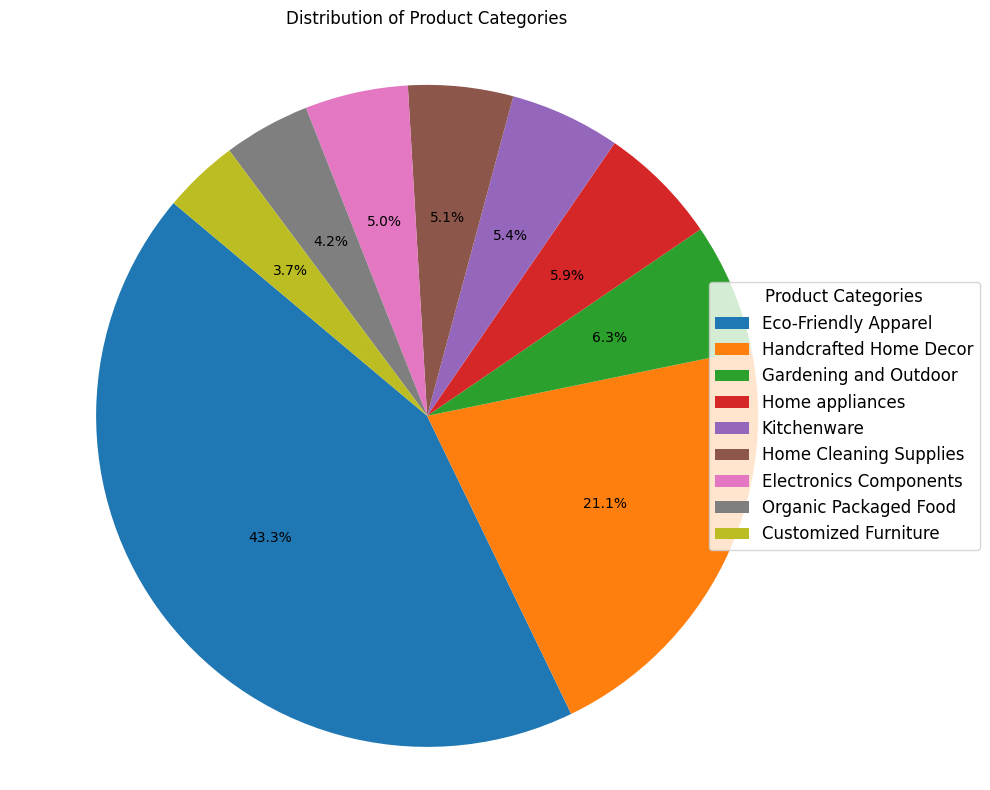

In [30]:
# Numer of orders for each product category
category_counts = df['product_group'].value_counts()

plt.figure(figsize=(10, 8))
plt.pie(category_counts, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Product Categories', pad=20)
plt.axis('equal')

# Show the plot
plt.legend(title="Product Categories", loc='center', bbox_to_anchor=(1, 0.5), labels=category_counts.index, fontsize='large', title_fontsize='large')

plt.tight_layout()
plt.show()

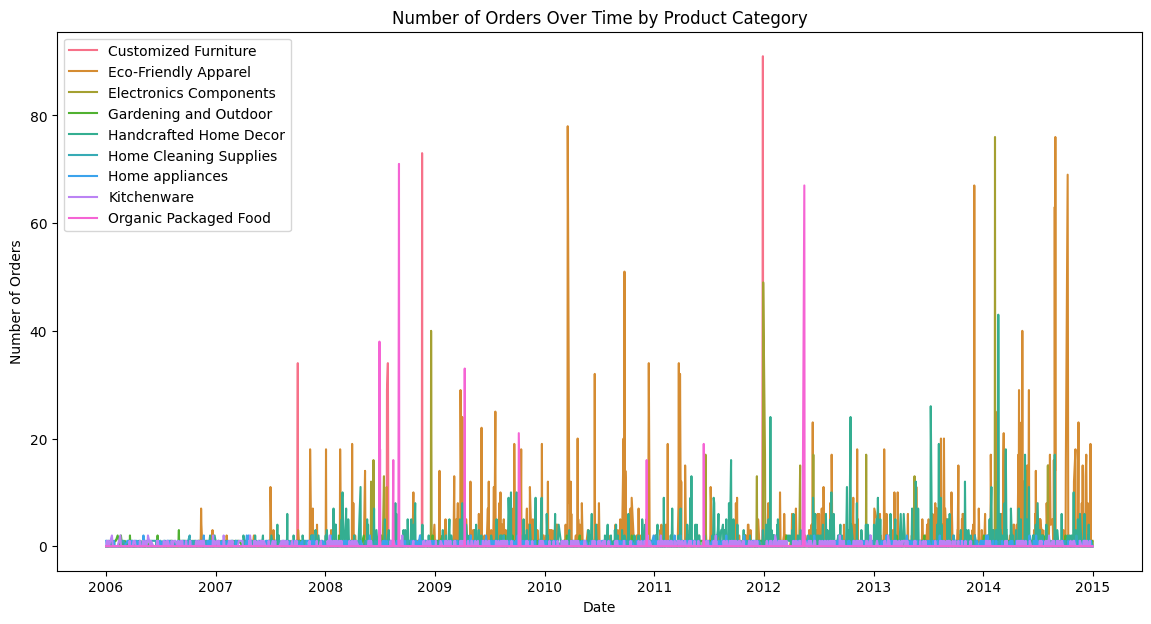

In [31]:
# Convert 'warehouse_date' to datetime
df['warehouse_date'] = pd.to_datetime(df['warehouse_date'])

# Time Series Analysis
df_time_series = df.groupby(['warehouse_date', 'product_group']).size().unstack(fill_value=0)

# Register matplotlib converters
register_matplotlib_converters()

# Show the plot
plt.figure(figsize=(14, 7))
plt.title('Number of Orders Over Time by Product Category')
plt.xlabel('Date')
plt.ylabel('Number of Orders')

palette = sns.color_palette("husl", len(df_time_series.columns))

for column, color in zip(df_time_series.columns, palette):
    plt.plot(df_time_series.index, df_time_series[column], label=column, color=color)

plt.legend()
plt.show()

<ipython-input-32-a4ed0c5851c6>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mean_ltl_cost_volume, x='ltl_cost', y='product_group', palette='coolwarm')
<ipython-input-32-a4ed0c5851c6>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mean_ltl_cost_volume, x='volume', y='product_group', palette='coolwarm')


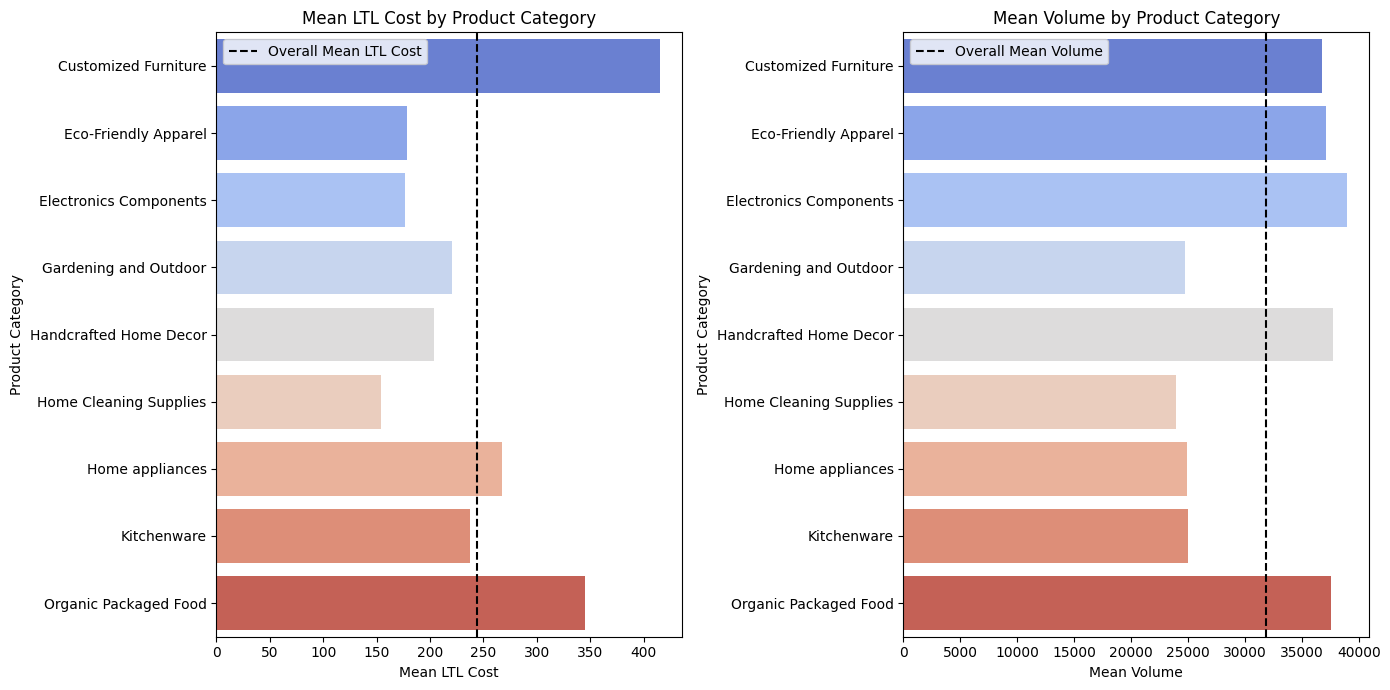

In [32]:
# Mean LTL cost and volume for each product category
mean_ltl_cost_volume = df.groupby('product_group')[['ltl_cost', 'volume']].mean().reset_index()

# Plotting the means as a bar plot with an emphasis on outliers
plt.figure(figsize=(14, 7))

# Plot for mean LTL cost
plt.subplot(1, 2, 1)
sns.barplot(data=mean_ltl_cost_volume, x='ltl_cost', y='product_group', palette='coolwarm')
plt.title('Mean LTL Cost by Product Category')
plt.xlabel('Mean LTL Cost')
plt.ylabel('Product Category')

# Adding a line for the overall mean to help identify outliers
overall_mean_ltl_cost = mean_ltl_cost_volume['ltl_cost'].mean()
plt.axvline(overall_mean_ltl_cost, color='k', linestyle='--', label='Overall Mean LTL Cost')
plt.legend()

# Plot for mean Volume
plt.subplot(1, 2, 2)
sns.barplot(data=mean_ltl_cost_volume, x='volume', y='product_group', palette='coolwarm')
plt.title('Mean Volume by Product Category')
plt.xlabel('Mean Volume')
plt.ylabel('Product Category')

# Adding a line for the overall mean to help identify outliers
overall_mean_volume = mean_ltl_cost_volume['volume'].mean()
plt.axvline(overall_mean_volume, color='k', linestyle='--', label='Overall Mean Volume')
plt.legend()

plt.tight_layout()
plt.show()

**LP Model for Naive method**

In [33]:
# Initialize the LP problem. The goal is to minimize the total shipping cost
lp_problem = LpProblem("Minimize_Shipping_Costs", LpMinimize)

# Variables
x_vars = {row['order_id']: LpVariable(f"x_{row['order_id']}", cat='Binary') for index, row in df.iterrows()}

# Objective Function
objective = lpSum([(row['tl_cost'] * x_vars[row['order_id']]) +
                   (row['ltl_cost'] * (1 - x_vars[row['order_id']])) for index, row in df.iterrows()])

lp_problem += objective

# Constraints
for index, row in df.iterrows():
    if row['volume'] <= 10000:
        # Must use LTL
        lp_problem += x_vars[row['order_id']] == 0, f"Order_{row['order_id']}_Volume_{index}_Must_Use_LTL"
    elif row['volume'] > 30000:
        # Must use TL
        lp_problem += x_vars[row['order_id']] == 1, f"Order_{row['order_id']}_Volume_{index}_Must_Use_TL"

# Solve the problem
status = lp_problem.solve(PULP_CBC_CMD(msg=0))  # msg=0 suppresses the solver output

# Check if the solution is feasible and display the results
solution_status = LpStatus[lp_problem.status]
solution = {order_id: x_var.varValue for order_id, x_var in x_vars.items()}

In [34]:
# calculate shipping cost
def calculate_shipping_costs(row):
    cost = row['ltl_cost'] if row['volume'] <= 10000 else row['tl_cost']
    method = 'LTL' if row['volume'] <= 10000 else 'TL'
    return method, cost

df['shipping_method'], df['chosen_cost'] = zip(*df.apply(calculate_shipping_costs, axis=1))

# Calculate the total and average costs
total_cost = df['chosen_cost'].sum()
average_cost_per_order = df['chosen_cost'].mean()

# Calculate the total and average cost per shipment for each product category
total_cost_per_category = df.groupby('product_group')['chosen_cost'].sum()
average_cost_per_category = df.groupby('product_group')['chosen_cost'].mean()

# Calculate the number of TL and LTL shipments overall
total_LTL = df[df['shipping_method'] == 'LTL'].shape[0]
total_TL = df[df['shipping_method'] == 'TL'].shape[0]

# Calculate the number of TL and LTL shipments for each product category
shipments_per_category = df.groupby(['product_group', 'shipping_method']).size().unstack(fill_value=0)

total_cost, average_cost_per_order, total_cost_per_category, average_cost_per_category, total_LTL, total_TL, shipments_per_category


(6096909,
 862.6073853989814,
 product_group
 Customized Furniture       232290
 Eco-Friendly Apparel      2722510
 Electronics Components     316840
 Gardening and Outdoor      355644
 Handcrafted Home Decor    1324320
 Home Cleaning Supplies     268996
 Home appliances            319088
 Kitchenware                291111
 Organic Packaged Food      266110
 Name: chosen_cost, dtype: int64,
 product_group
 Customized Furniture      890.000000
 Eco-Friendly Apparel      890.000000
 Electronics Components    890.000000
 Gardening and Outdoor     797.408072
 Handcrafted Home Decor    890.000000
 Home Cleaning Supplies    743.082873
 Home appliances           767.038462
 Kitchenware               764.070866
 Organic Packaged Food     890.000000
 Name: chosen_cost, dtype: float64,
 308,
 6760,
 shipping_method         LTL    TL
 product_group                    
 Customized Furniture      0   261
 Eco-Friendly Apparel      0  3059
 Electronics Components    0   356
 Gardening and Outdoor   

**Consolidation method without time constraint**

In [35]:
# Divide orders into 2 categories: large and small with the threadhold as TL capacity
large_orders = df[df['volume'] > 30000]
small_orders = df[df['volume'] <= 30000]

# Calculate full shipments for large orders and potential remainders for merging
full_shipments_large_orders = large_orders['volume'] // 30000
remainders_large_orders = large_orders['volume'] % 30000

# Count the guaranteed full shipments from large orders
num_full_shipments_large = full_shipments_large_orders.sum()

# Prepare the list of volumes for orders below 30,000 lbs or are remainders for merging
merge_candidates_volumes = small_orders['volume'].tolist() + remainders_large_orders[remainders_large_orders > 0].tolist()

In [36]:
# Define the problem
prob = LpProblem("Truckload_Shipment_Consolidation", LpMinimize)

# Decision variables
x_vars = LpVariable.dicts("Ship", range(len(merge_candidates_volumes)), cat='Binary')

# Objective function
prob += lpSum(x_vars)

# Constraint
for i in range(len(merge_candidates_volumes)):
    prob += merge_candidates_volumes[i] * x_vars[i] <= 30000, f"VolumeConstraint_{i}"

# Solve the problem
prob.solve(PULP_CBC_CMD(msg=False))

# Check the status of the solution
solution_status = LpStatus[prob.status]
solution_status

'Optimal'

In [37]:
def create_merged_shipments(volumes, max_capacity=30000):
    # Sort the volumes in descending order to prioritize larger volumes
    sorted_volumes = sorted(volumes, reverse=True)
    shipments = 0
    while sorted_volumes:
        current_capacity = 0
        for volume in sorted_volumes[:]:
            if current_capacity + volume <= max_capacity:
                current_capacity += volume
                sorted_volumes.remove(volume)
        shipments += 1  # Each iteration represents a new shipment

    return shipments

In [38]:
# Separate orders into categories
categories = df['product_group'].unique()

# Initialize a dictionary to hold results for each category
category_results = {
    category: {'full_shipments': 0, 'merged_shipments': 0, 'total_cost': 0} for category in categories
}

# Calculate full shipments for large orders by category
for category in categories:
    category_large_orders = large_orders[large_orders['product_group'] == category]
    num_full_shipments_category = category_large_orders['volume'] // 30000
    category_results[category]['full_shipments'] = num_full_shipments_category.sum()

cost_per_shipment = 890

# Calculate merged shipments for each category
for category in categories:
    category_small_orders = small_orders[small_orders['product_group'] == category]['volume'].tolist()
    category_remainders = remainders_large_orders[large_orders['product_group'] == category]
    category_remainders_list = category_remainders[category_remainders > 0].tolist()
    merge_candidates_category = category_small_orders + category_remainders_list
    num_merged_shipments_category = create_merged_shipments(merge_candidates_category)
    category_results[category]['merged_shipments'] = num_merged_shipments_category
    # Calculate total shipments and costs
    total_shipments_category = category_results[category]['full_shipments'] + num_merged_shipments_category
    total_cost_category = total_shipments_category * cost_per_shipment
    category_results[category]['total_cost'] = total_cost_category

category_results


{'Eco-Friendly Apparel': {'full_shipments': 2106,
  'merged_shipments': 1885,
  'total_cost': 3551990},
 'Handcrafted Home Decor': {'full_shipments': 1063,
  'merged_shipments': 894,
  'total_cost': 1741730},
 'Organic Packaged Food': {'full_shipments': 186,
  'merged_shipments': 226,
  'total_cost': 366680},
 'Customized Furniture': {'full_shipments': 181,
  'merged_shipments': 147,
  'total_cost': 291920},
 'Electronics Components': {'full_shipments': 303,
  'merged_shipments': 161,
  'total_cost': 412960},
 'Home appliances': {'full_shipments': 163,
  'merged_shipments': 183,
  'total_cost': 307940},
 'Kitchenware': {'full_shipments': 157,
  'merged_shipments': 162,
  'total_cost': 283910},
 'Gardening and Outdoor': {'full_shipments': 172,
  'merged_shipments': 197,
  'total_cost': 328410},
 'Home Cleaning Supplies': {'full_shipments': 129,
  'merged_shipments': 161,
  'total_cost': 258100}}

**Consolidation method with time constraint**

In [44]:
# Convert delivery_due_date from string to datetime
df['delivery_due_date'] = pd.to_datetime(df['delivery_due_date'])

# Divide orders into large and small categories based on the TL capacity
large_orders = df[df['volume'] > 30000]
small_orders = df[df['volume'] <= 30000]

# Calculate full shipments for large orders
full_shipments_large_orders = large_orders['volume'] // 30000
num_full_shipments_large = full_shipments_large_orders.sum()

# List of volumes for small orders and remainders from large orders for merging
merge_candidates = pd.concat([
    small_orders,
    large_orders[large_orders['volume'] % 30000 > 0].assign(volume=lambda x: x['volume'] % 30000)
])

# Initialize a dictionary to hold results for each category
category_results = {
    category: {'full_shipments': 0, 'merged_shipments': 0, 'total_cost': 0}
    for category in df['product_group'].unique()
}

# Calculate full shipments for large orders by category
for category in df['product_group'].unique():
    category_large_orders = large_orders[large_orders['product_group'] == category]
    category_results[category]['full_shipments'] = category_large_orders['volume'] // 30000

#   Create merged shipments within each category considering time constraints
def create_merged_shipments_with_dates(orders, max_capacity=30000):
    orders = orders.sort_values(by='delivery_due_date')
    total_shipments = 0
    current_shipment_volume = 0
    for _, order in orders.iterrows():
        if current_shipment_volume + order['volume'] <= max_capacity:
            current_shipment_volume += order['volume']
        else:
            total_shipments += 1
            current_shipment_volume = order['volume']  # Start new shipment
    if current_shipment_volume > 0:  # Account for the last shipment
        total_shipments += 1
    return total_shipments

# Calculate merged shipments for each category considering the time constraint
cost_per_shipment = 890

for category in df['product_group'].unique():
    category_orders = merge_candidates[merge_candidates['product_group'] == category]
    num_merged_shipments = create_merged_shipments(category_orders)
    category_results[category]['merged_shipments'] = num_merged_shipments
    total_shipments = num_full_shipments_large + num_merged_shipments
    category_results[category]['total_cost'] = total_shipments * cost_per_shipment

# Initialize results container
category_results = {
    category: {'full_shipments': 0, 'merged_shipments': 0, 'total_cost': 0}
    for category in df['product_group'].unique()
}

# Process each category
for category in df['product_group'].unique():
    # Extract full shipments count for large orders in this category
    category_full_shipments = (large_orders['volume'] // 30000)[large_orders['product_group'] == category].sum()
    category_results[category]['full_shipments'] = category_full_shipments

    # Prepare merge candidates including small orders and remainders from large orders
    category_small_orders = small_orders[small_orders['product_group'] == category]
    category_remainders = remainders_large_orders[large_orders['product_group'] == category]
    merge_candidates = pd.concat([category_small_orders, category_remainders])

    # Calculate merged shipments considering due dates
    num_merged_shipments = create_merged_shipments_with_dates(merge_candidates)
    category_results[category]['merged_shipments'] = num_merged_shipments

    # Calculate total shipments and costs for this category
    total_shipments = category_full_shipments + num_merged_shipments
    total_cost = total_shipments * cost_per_shipment  # Assuming cost_per_shipment is defined
    category_results[category]['total_cost'] = total_cost

category_results

{'Eco-Friendly Apparel': {'full_shipments': 2106,
  'merged_shipments': 3053,
  'total_cost': 4591510},
 'Handcrafted Home Decor': {'full_shipments': 1063,
  'merged_shipments': 1483,
  'total_cost': 2265940},
 'Organic Packaged Food': {'full_shipments': 186,
  'merged_shipments': 298,
  'total_cost': 430760},
 'Customized Furniture': {'full_shipments': 181,
  'merged_shipments': 260,
  'total_cost': 392490},
 'Electronics Components': {'full_shipments': 303,
  'merged_shipments': 355,
  'total_cost': 585620},
 'Home appliances': {'full_shipments': 163,
  'merged_shipments': 336,
  'total_cost': 444110},
 'Kitchenware': {'full_shipments': 157,
  'merged_shipments': 301,
  'total_cost': 407620},
 'Gardening and Outdoor': {'full_shipments': 172,
  'merged_shipments': 363,
  'total_cost': 476150},
 'Home Cleaning Supplies': {'full_shipments': 129,
  'merged_shipments': 291,
  'total_cost': 373800}}